The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Start training run 0!
Training model with 2531 parameters...
it 0: avgR: 20.732 -- rollout_time: 1.225sec -- update_time: 1.036sec
it 1: avgR: 20.111 -- rollout_time: 1.289sec -- update_time: 0.826sec
it 2: avgR: 21.274 -- rollout_time: 1.322sec -- update_time: 0.798sec


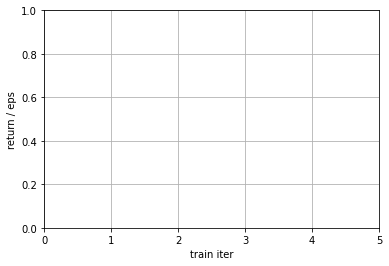

NameError: name 'base' is not defined

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

import utils
from utils import show_video
from utils import count_model_params
from utils import AverageMeter, plot_learning_curve
from utils import ParamDict

from IPython import display
from IPython.display import clear_output
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2



class PPO():
	def __init__(self, params_in):
		self.params = params_in
		# env
		self.env = self.gen_env()
		self.obs_size = self.env.observation_space.shape[0]
		self.num_actions = self.env.action_space.n
		# rollouts
		self.rollouts = self.RolloutStorage(self.params.rollout_size, self.obs_size)
		# policy
		self.init_policy(self.obs_size, self.num_actions, **self.params.policy_params)
	
	def init_policy(self, num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs,
				entropy_coef=0.001, critic_coef=0.5, clip_param=0.2):
		self.actor = self.ActorNetwork(num_inputs, num_actions, hidden_dim)
		self.critic = self.CriticNetwork(num_inputs, hidden_dim)
		self.critic_coef = critic_coef
		self.optimizer = optim.Adam( (list(self.actor.parameters()) + list(self.critic.parameters())), lr=learning_rate)
		self.batch_size = batch_size
		self.policy_epochs = policy_epochs
		self.entropy_coef = entropy_coef
		self.clip_param = clip_param

	def gen_env(self):
		# env = Monitor(gym.make(self.params.env_name), './video', force=True)
		# env = self.FlatObsWrapperCartPole(gym.make(self.params.env_name))
		env = gym.make(self.params.env_name)
		return env

	def act(self, state):
		logits = self.actor.forward(state)
		# print("logits: {}".format(logits))
		dist = Categorical(logits = logits)
		# print("dist: {}".format(dist))
		action = dist.sample()
		# print("action: {}".format(action))
		log_prob = dist.log_prob(action)
		# print("log_prob: {}".format(log_prob))
		return action, log_prob
	
	def update(self, rollouts):	
		for epoch in range(self.policy_epochs):
			data = rollouts.batch_sampler(self.batch_size, get_old_log_probs=True)
			for sample in data:
				actions_batch, returns_batch, obs_batch, old_log_probs_batch = sample
				log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
				
				value_batch = self.critic(obs_batch)
				
				advantage = returns_batch - value_batch.detach()
				old_log_probs_batch = old_log_probs_batch.detach()

				ratio = torch.exp(log_probs_batch-old_log_probs_batch)
				surr1 = ratio * advantage
				surr2 = torch.clamp(ratio,1-self.clip_param, 1+ self.clip_param) * advantage

				policy_loss = -1 * (torch.min(surr1,surr2).mean())
				entropy_loss = -1 * ((entropy_batch).mean())
				loss = torch.nn.MSELoss()
				critic_loss = loss(returns_batch,value_batch)   
				loss = policy_loss + \
						self.critic_coef * critic_loss + \
						self.entropy_coef * entropy_loss

				self.optimizer.zero_grad()
				loss.backward(retain_graph=False)
				self.optimizer.step()
	
	def evaluate_actions(self, state, action):
		logits = self.actor.forward(state)
		dist = Categorical(logits = logits)
		log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)  # ???
		entropy = dist.entropy().view(-1, 1)
		return log_prob, entropy

	def log_policy_rollout(self, policy, env_name, pytorch_policy=False):
		env = Monitor(gym.make(env_name), './video', force=True)
		# env = gym.make(env_name)
		# env.monitor.start('./video', force=True)

		done = False
		episode_reward = 0
		episode_length = 0
		observation = env.reset()

		while not done:
			if pytorch_policy: 
				observation = torch.tensor(observation, dtype=torch.float32)
				action = policy.act(observation)[0].data.cpu().numpy()
			else:
				action = policy.act(observation)[0]
			observation, reward, done, info = env.step(action)

			episode_reward += reward
			episode_length += 1

		print('Total reward:', episode_reward)
		print('Total length:', episode_length)

		env.close()
		# env.monitor.close()
		show_video()
	
	def train(self, seed=123):
		# SETTING SEED: it is good practice to set seeds when running experiments to keep results comparable
		np.random.seed(seed)
		torch.manual_seed(seed)
		self.env.seed(seed)

		rollout_time, update_time = AverageMeter(), AverageMeter()  # Loggers
		rewards, success_rate = [], []

		print("Training model with {} parameters...".format(self.num_params))

		for j in range(self.params.num_updates):
			## initialization
			avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
			done = False
			prev_obs = self.env.reset()
			# print(prev_obs)
			prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
			eps_reward = 0.
			start_time = time.time()
			
			## collect rollouts
			for step in range(self.rollouts.rollout_size):
				if done:
					# store episode statistics
					avg_eps_reward.update(eps_reward)
					if 'success' in info: 
						avg_success_rate.update(int(info['success']))

					# reset Environment
					obs = self.env.reset()
					obs = torch.tensor(obs, dtype=torch.float32)
					eps_reward = 0.
				else:
					obs = prev_obs

				action, log_prob = self.act(obs)
				obs, reward, done, info = self.env.step(action.item())
				self.rollouts.insert(step, torch.tensor(done, dtype=torch.float32),\
								action, log_prob, torch.tensor(reward, dtype=torch.float32), prev_obs[0])
				
				prev_obs = torch.tensor(obs, dtype=torch.float32)
				eps_reward += reward
			
			self.rollouts.compute_returns(self.params.discount)
			rollout_done_time = time.time()
			self.update(self.rollouts)

			update_done_time = time.time()
			self.rollouts.reset()

			## log metrics
			rewards.append(avg_eps_reward.avg)
			if avg_success_rate.count > 0:
				success_rate.append(avg_success_rate.avg)
			rollout_time.update(rollout_done_time - start_time)
			update_time.update(update_done_time - rollout_done_time)
			print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j, avg_eps_reward.avg, 
																									rollout_time.avg, 
																									update_time.avg))
			if j % self.params.plotting_iters == 0 and j != 0:
				plot_learning_curve(rewards, success_rate, self.params.num_updates)
				self.log_policy_rollout(self, self.params.env_name, True)
		# render learning logger
		clear_output()   # this removes all training outputs to keep the notebook clean
		# plot_learning_curve(rewards, success_rate, params.num_updates)
		# for _ in range(3):
		# 	self.log_policy_rollout(self, self.params.env_name, True)
		return rewards, success_rate
		
	@property
	def num_params(self):
		return count_model_params(self.actor) + count_model_params(self.critic)
	

	class FlatObsWrapperCartPole(gym.core.ObservationWrapper):
		"""Fully observable gridworld returning a flat grid encoding."""
		def __init__(self, env):
			super().__init__(env)
			self.observation_space = spaces.Box(
				low=0,
				high=255,
				shape=((env.observation_space['image'].shape[0]) * (env.observation_space['image'].shape[1]) * 3,),  # number of cells
				dtype='uint8'
			)
			self.unwrapped.max_steps = env.max_steps

		def observation(self, obs):
			# this method is called in the step() function to get the observation
			# we provide code that gets the grid state and places the agent in it
			env = self.unwrapped
			full_grid = env.grid.encode()
			# full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
			# 	OBJECT_TO_IDX['agent'],
			# 	COLOR_TO_IDX['red'],
			# 	env.agent_dir
			# ])
			# full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
			flattened_grid = full_grid.reshape((np.prod(full_grid.shape),1))
			return np.transpose(flattened_grid)
		
		def render(self, *args, **kwargs):
			kwargs['highlight'] = False
			return self.unwrapped.render(*args, **kwargs)

	class ActorNetwork(nn.Module):
		def __init__(self, num_inputs, num_actions, hidden_dim):
			super().__init__()
			self.num_actions = num_actions
			self.fc = nn.Sequential(nn.Linear(num_inputs,hidden_dim),
									nn.Tanh(),
									nn.Linear(hidden_dim,hidden_dim),
									nn.Tanh(),
									nn.Linear(hidden_dim, self.num_actions))
									# no activation in NN, output logit
		
		def forward(self, state):
			x = self.fc(state)
			return x
	
	class CriticNetwork(nn.Module):
		def __init__(self, num_inputs, hidden_dim):
			super().__init__()
			self.fc = nn.Sequential(nn.Linear(num_inputs,hidden_dim),
									nn.Tanh(),
									nn.Linear(hidden_dim,hidden_dim),
									nn.Tanh(),
									nn.Linear(hidden_dim,1))

		def forward(self, state):
			x = self.fc(state)
			return x
	
	class RolloutStorage():
		def __init__(self, rollout_size, obs_size):
			self.rollout_size = rollout_size
			self.obs_size = obs_size
			self.reset()

		def insert(self, step, done, action, log_prob, reward, obs):	
			self.done[step].copy_(done)
			self.actions[step].copy_(action)
			self.log_probs[step].copy_(log_prob)
			self.rewards[step].copy_(reward)
			self.obs[step].copy_(obs)

		def reset(self):
			self.done = torch.zeros(self.rollout_size, 1)
			self.returns = torch.zeros(self.rollout_size+1, 1, requires_grad=False)
			self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)
			self.log_probs = torch.zeros(self.rollout_size, 1)
			self.rewards = torch.zeros(self.rollout_size, 1)
			self.obs = torch.zeros(self.rollout_size, self.obs_size)

		def compute_returns(self, gamma):
			self.last_done = (self.done == 1).nonzero().max()
			self.returns[self.last_done+1] = 0.  # ???

			#  compute finite-discoiunted return
			for step in reversed(range(self.last_done+1)):
				self.returns[step] = self.returns[step + 1] * \
					gamma * (1 - self.done[step]) + self.rewards[step]

		def batch_sampler(self, batch_size, get_old_log_probs=False):
			# build a generator of single-trajectory: (a, r, s, pi(a, t)) 
			sampler = BatchSampler(
				SubsetRandomSampler(range(self.last_done)),
				batch_size,
				drop_last=True)
			for indices in sampler:
				if get_old_log_probs:
					yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
				else:
					yield self.actions[indices], self.returns[indices], self.obs[indices]

# Test Trian
# hyperparameters
policy_params = ParamDict(
	# policy_class = PPO,  # Policy class to use (replaced later)
	hidden_dim = 32,		  # dimension of the hidden state in actor network
	learning_rate = 1e-3,	 # learning rate of policy update
	batch_size = 1024,		# batch size for policy update
	policy_epochs = 4,		# number of epochs per policy update
	entropy_coef = 0.001,	 # hyperparameter to vary the contribution of entropy loss
	critic_coef = 0.5		 # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
	policy_params = policy_params,
	rollout_size = 2050,	  # number of collected rollout steps per policy update
	num_updates = 6,		# number of training policy iterations
	discount = 0.99,		  # discount factor
	plotting_iters = 2,	  # interval for logging graphs and policy rollouts
	env_name = 'CartPole-v1',  # we are using a tiny environment here for testing
)



# ppo = PPO(params)
# ppo.train()
# print("Training completed!")

n_seeds = 3
rewards, success_rates = [], []
for i in range(n_seeds):
	ppo = PPO(params)
	print("Start training run {}!".format(i))
	r, sr = ppo.train(i)
	rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
print("Average Reward: {}".format(np.mean(rewards, axis=0)[-1]))
print("Average Success Rates: {}".format(np.mean(success_rates, axis=0)[-1]))
